# FAST HI观测规划助手`obshelper`示例3：多次的Drift或者多波束OTF扫描巡天

by astroR2 2025/5/10

* 示例3将介绍如何使用本程序包批量规划`DriftWithAngle`或者`MultibeamOTF`模式的巡天。

* 天顶角与合适的观测时间的检查请见另一个例子。

* 注意：本程序与FAST官方无关，纯个人开发使用，请仔细检查输出结果，如有错误概不负责。请务必先详细阅读[FAST观测常见问题](https://fast.bao.ac.cn/cms/article/147/)与[用户帮助文档](https://fast.bao.ac.cn/cms/article/80/)。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import hiviewer as hv
import os

from obshelper.opt_source import OptSource
from obshelper.utils.util import line_set

from astropy.coordinates import SkyCoord
from astropy import units as u

## M31的多次DriftWithAngle观测

这里只是举个例子，MultibeamOTF同理，只要设置好所有坐标的中心，并不是真实的观测。

In [2]:
# 后面会在此fits图像的wcs基础上画图，射电的、光学的任意波段都可以
m0 = hv.FitsPic('./data/M31_DSS2 Red_0-opt.fits')

Showing image.


<WCSAxes: >

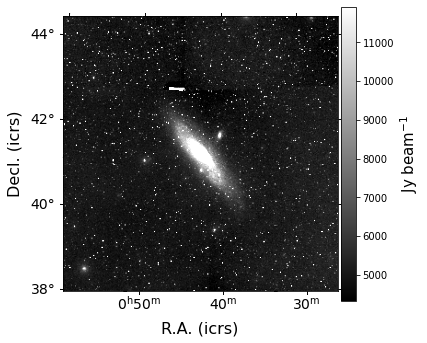

In [3]:
m0.plot_slice(per_vmin_max=0.98)

In [4]:
# M31的坐标
m31_ra, m31_dec = 10.684799, 41.269076

# 使用OTF时间计算器
from obshelper.MultiBeamOTF_Time import MultiOTFcalculator

因为前面写过OTF的例子了，这次写drift的。注意中心和起始点的差别。

In [5]:
# 19波束在23.4度转角的宽度
scan_gap = 21.66 # arcmin

# 构建坐标数组的参考点
c0 = SkyCoord(m31_ra, m31_dec + 1.5, unit= (u.deg,u.deg))
ra0, dec0 = c0.ra.value, c0.dec.value

# 起始和终止RA
ra1, ra2 = m31_ra - 4, m31_ra + 4

如果你想在每个drift之间重复加密扫描，但是Dec方向错开一点点达到更好的Nyquist采样，只要改这个部分的坐标即可。

In [6]:
# 扫描drift的总条数
N = 10

# 中心ra固定
center_ras = np.full(N, ra0)

# 所有的中心dec，相对于参考点是向下平移的
center_decs = dec0 + np.arange(0, -N, -1) * scan_gap / 60 # deg 中心

# 跨度
Delta_RA = np.full(N, ra2 - ra1) * 60 # arcmin 固定值
Delta_DEC = np.full(N, 0) # arcmin 不转弯，0

In [7]:
# 计算时间

otcs = []

i = 0
for ra, dec in zip(center_ras, center_decs):
    print(i)
    otc = MultiOTFcalculator(ra, dec, diff_ra = Delta_RA[i], diff_dec = Delta_DEC[i])
    otc.get_startend()
    # 因为不转弯，扫描间隔随便写。drift的扫描速度是地球自转。
    otc.input_OTF_para(direction = '-', scan_gap = 21.66, scan_speed = 15) 
    otc.calculate_time()
    
    print("Time used: ", otc.tot_time.to(u.hour))

    otcs += [otc, ]
    i += 1

0
MultiBeam OTF, direction:  -
Scan gap: 21.66 arcmin
Scan speed: 15.0 arcsec / s
Scan 1.0 times along -, switch 0.0 times.
Need total 1920.0 s = 32.0 min.
Time used:  0.5333333333333333 h
1
MultiBeam OTF, direction:  -
Scan gap: 21.66 arcmin
Scan speed: 15.0 arcsec / s
Scan 1.0 times along -, switch 0.0 times.
Need total 1920.0 s = 32.0 min.
Time used:  0.5333333333333333 h
2
MultiBeam OTF, direction:  -
Scan gap: 21.66 arcmin
Scan speed: 15.0 arcsec / s
Scan 1.0 times along -, switch 0.0 times.
Need total 1920.0 s = 32.0 min.
Time used:  0.5333333333333333 h
3
MultiBeam OTF, direction:  -
Scan gap: 21.66 arcmin
Scan speed: 15.0 arcsec / s
Scan 1.0 times along -, switch 0.0 times.
Need total 1920.0 s = 32.0 min.
Time used:  0.5333333333333333 h
4
MultiBeam OTF, direction:  -
Scan gap: 21.66 arcmin
Scan speed: 15.0 arcsec / s
Scan 1.0 times along -, switch 0.0 times.
Need total 1920.0 s = 32.0 min.
Time used:  0.5333333333333333 h
5
MultiBeam OTF, direction:  -
Scan gap: 21.66 arcmin
S

Showing image.
Total times (include switching 10 min) 7.000 hours
Total times (not include switching 10 min) 5.333 hours


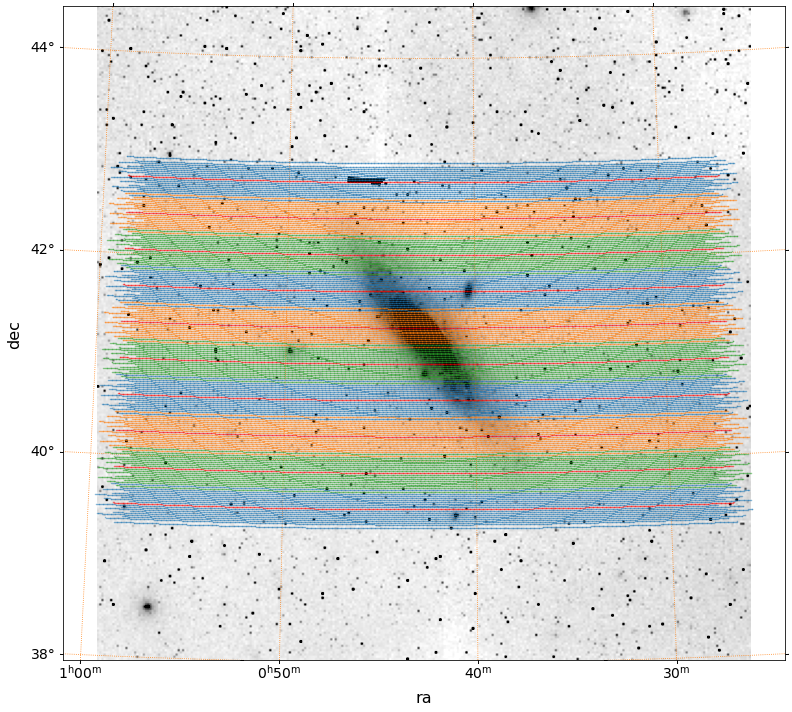

In [8]:
ax = m0.plot_slice(cmap = 'gray_r', per_vmin_max= 0.98, colorbar=False, figsize = (12, 10),  )
ax.grid(color = 'C1',ls = ':')

i = 0
total_time1 = 0
total_time2 = 0
# Area = 0
for otc in otcs:
    otc.show_footprints(ax, m0, sample_time = 0.5, 
                    gap = 5, ms = 1, alpha = 0.5, color = f'C{i%3}', Print = False)

    # 观测时间
    total_time1 += otc.tot_time.to(u.hour).value + 10 / 60
    total_time2 += otc.tot_time.to(u.hour).value
    i += 1
    
print(f"Total times (include switching 10 min) {total_time1:.3f} hours")
print(f"Total times (not include switching 10 min) {total_time2:.3f} hours")
plt.show()

当然，需要指明的，以上只是示例，如果你观测时间很多，一次drift的时间要尽可能长才划算，要不每颗源10分钟扣着很难受。

Showing image.


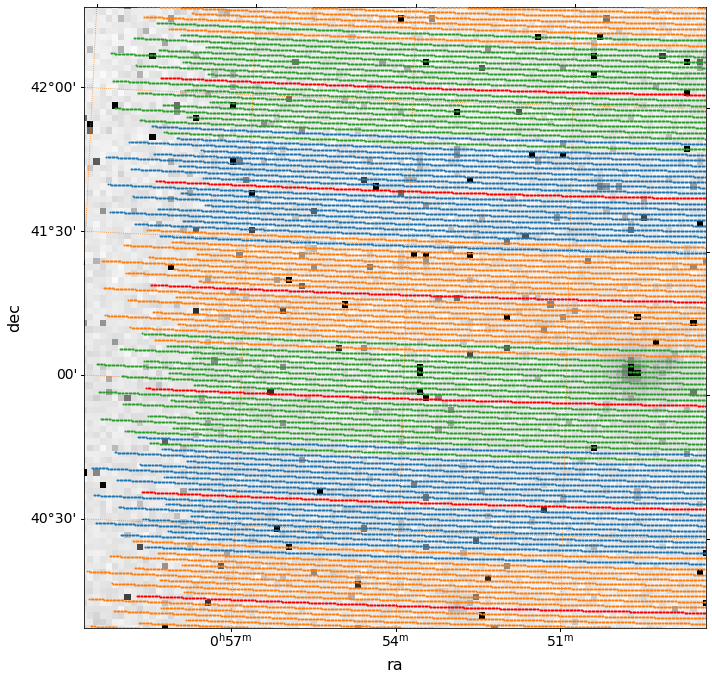

In [9]:
# 检查scan gap有无设置错误，都是等间隔的
ax = m0.plot_slice(cmap = 'gray_r', per_vmin_max= 0.98, colorbar=False, figsize = (10, 20),  
                  xylim=(0, 100, 100, 200))
ax.grid(color = 'C1',ls = ':')
i = 0
for otc in otcs:
    otc.show_footprints(ax, m0, sample_time = 0.5, 
                    gap = 3, ms = 2, alpha = 1, color = f'C{i%3}', Print = False)
    i += 1

In [10]:
# 生成FAST要求的txt格式，也可以复制粘贴手动提交
header = ["#Source Name", "Observation Mode", "RA(hh:mm:ss.ss)", "DEC(dd:mm:ss.s)",  
         "time(sec)"]

df = pd.DataFrame(columns=header)
def format_radec(pos):
    ra1 = pos.ra.to_string(unit = u.hourangle, sep = ':', precision=2, pad = True)
    dec1 = pos.dec.to_string(unit = u.degree, sep = ':', precision=1, alwayssign = True)
    return ra1, dec1

coos = []
coos_s = []
coos_e = []
otcs_ = []
for i in range(len(otcs)):
    otc = otcs[i]
    
    ra_, dec_ = format_radec(otc.center)
    ra_start, dec_start = format_radec(otc.start)
    ra_end, dec_end = format_radec(otc.end)
    
    otcs_ += [otc]
    coos += [ra_+ ' ' + dec_]
    coos_s += [ra_start+ ' ' + dec_start]
    coos_e += [ra_end+ ' ' + dec_end]

    t = otc.tot_time.to(u.second).value
    df.loc[i] = [f"M31_{i:02d}", "DriftWithAngle", ra_start, dec_start, t]
    # 注意编号

**注意**Drift的对准时间是开始时间的话，输入的坐标是起始点，小赤经才对。

In [11]:
# 检查坐标
coo = SkyCoord(coos, unit=(u.hourangle, u.deg))
coo_s = SkyCoord(coos_s, unit=(u.hourangle, u.deg))
coo_e = SkyCoord(coos_e, unit=(u.hourangle, u.deg))

In [12]:
# 21.66'
np.diff(coo.dec[np.argsort(coo.dec)])

<Latitude [0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361] deg>

In [13]:
# 观测天区面积，加减0.038度是最上面和最下面采样不足的gap
from obshelper.utils.util import area
def print_area(otcs_, coo, coo_s, coo_e):
    ra1, ra2 = coo_s.ra[0].value, coo_e.ra[0].value
    dec1 = np.min(otcs_[np.argmin(coo.dec)].dec_all) + 0.038
    dec2 = np.max(otcs_[np.argmax(coo.dec)].dec_all) - 0.038
    
    print(f"ra1, ra2, dec1, dec2 = [{ra1:.1f}, {ra2:.1f}, {dec1:.3f}, {dec2:.3f}]")
    
    A = area(ra1, ra2, dec1, dec2)
    print("area is ", A)

print_area(otcs_, coo, coo_s, coo_e) 

ra1, ra2, dec1, dec2 = [6.7, 14.7, 39.368, 42.921]
area is  21.401615812946087 deg2


In [14]:
df

,#Source Name,Observation Mode,RA(hh:mm:ss.ss),DEC(dd:mm:ss.s),time(sec)
0,M31_00,DriftWithAngle,00:26:44.35,+42:46:08.7,1920.0
1,M31_01,DriftWithAngle,00:26:44.35,+42:24:29.1,1920.0
2,M31_02,DriftWithAngle,00:26:44.35,+42:02:49.5,1920.0
3,M31_03,DriftWithAngle,00:26:44.35,+41:41:09.9,1920.0
4,M31_04,DriftWithAngle,00:26:44.35,+41:19:30.3,1920.0
5,M31_05,DriftWithAngle,00:26:44.35,+40:57:50.7,1920.0
6,M31_06,DriftWithAngle,00:26:44.35,+40:36:11.1,1920.0
7,M31_07,DriftWithAngle,00:26:44.35,+40:14:31.5,1920.0
8,M31_08,DriftWithAngle,00:26:44.35,+39:52:51.9,1920.0
9,M31_09,DriftWithAngle,00:26:44.35,+39:31:12.3,1920.0


In [15]:
# 保存时不需要最后一列时间列
df[df.keys()[:-1]].to_csv('./obsfile/M31_drift.txt', sep='|', index = False)